In [143]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Particle Filters

Suppose that we want to track a constant velocity object (e.g., a submarine) via a radar
device that only reports the angle to the object. In addition,
the angle measurements are noisy. We assume that the initial position and
velocity are known and that the object moves at a constant speed.
Let $X_t = (x_{1t}, v_{1t}, x_{2t}, v_{2t})^\top$ be the vector of positions and (discrete) velocities of the target object at time $t = 0, 1, 2, \ldots$, and let $Y_t$ be the measured
angle. The problem is to track the unknown state of the object $X_t$ based on
the measurements $\{Y_t\}$ and the initial conditions.

The process $(X_t,Y_t)$, $t = 0,1,2,...$ is described by the following system:
$$
\begin{aligned}
X_t &= A X_{t−1} +\varepsilon_{1t}\\
Y_t &= \arctan\left(\frac{x_{1t}}{x_{2t}}\right)+ε_{2t}
\end{aligned}
$$
where the matrix $A$ is given by
$$
A = \begin{pmatrix}
1 & 1 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 1 \\
0 & 0 & 0 & 1
\end{pmatrix},
$$
$\varepsilon_{1t}$ is a Gaussian noise vector with mean 0 and covariance matrix
$$
\Sigma_1 = \begin{pmatrix}
1/4 & 1/2 & 0 & 0 \\
1/2 & 1 & 0 & 0 \\
0 & 0 & 1/4 & 1/2 \\
0 & 0 & 1/4 & 1/2
\end{pmatrix},
$$
and $ε_{2t}$ is a Gaussian noise with mean 0 and variance $0.005$.



## 1. Initialization:

1. Initialize all the parameters of the system.
2. Generate the true states for $t = 1, \ldots, 25$. 
   For the initial state, use the state vector: 
  $$
  X_0 = (−0.05,0.001,0.2, −0.055)^T.
  $$
3. Plot trajectory of the true states $X_t$ for $t = 0, 1, \ldots, 25$. Mark the initial state with a red dot.
4. Generate the measurements for $t = 1, \ldots, 25$.
5. Plot the measurements $Y_t$ for $t = 1, \ldots, 25$.

Note that our sensor does not know the true states $X_t$, but only the measurements $Y_t$.



/var/folders/gj/76ncjg5s4hz3x1h644w2l4rm0000gn/T/ipykernel_72702/1388791295.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  eps_1t = np.random.multivariate_normal([0, 0, 0, 0], eps1t_cov, size=1000)


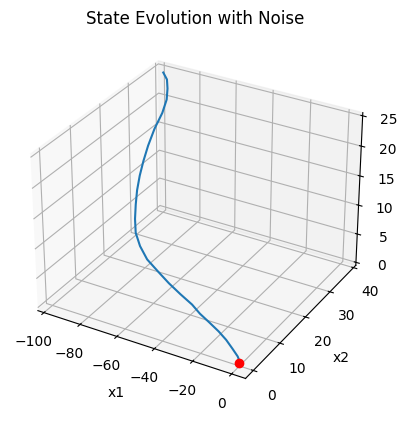

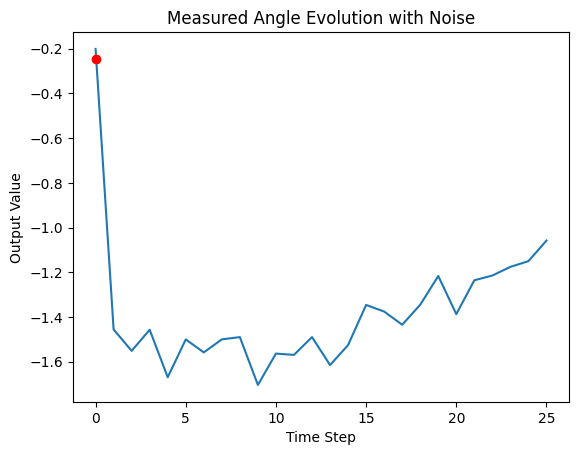

In [144]:
# initialization code
A = np.array([[1, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 1], [0, 0, 0, 1]])
eps1t_cov = np.array([[1/4, 1/2, 0, 0], [1/2, 1, 0, 0], [0, 0, 1/4, 1/2], [0, 0, 1/4, 1/2]])
eps_1t = np.random.multivariate_normal([0, 0, 0, 0], eps1t_cov, size=1000)
eps_2t = np.random.normal(0, np.sqrt(0.005), size=1000)
X0 = np.array([-0.05, 0.001, 0.2, -0.055]).transpose()
X_vec = [X0]

for i in range(25):
    X_next = A @ X_vec[i] + eps_1t[i]
    X_vec.append(X_next)

t = np.arange(0, 26)
plt.figure(0).add_subplot(projection='3d')
plt.plot(np.array(X_vec)[:, 0], np.array(X_vec)[:, 2], t, label='State Trajectory')
plt.plot(0, X0[0], 'ro', label='X0')
plt.title('State Evolution with Noise')
plt.xlabel('x1')
plt.ylabel('x2')

Y_vec = []
for i, x in enumerate(X_vec):
    Y_cur = np.arctan2(x[0], x[2]) + eps_2t[i]
    Y_vec.append(Y_cur)

plt.figure(1)
plt.plot(t, Y_vec)
plt.plot(0, np.arctan2(X0[0], X0[2]), 'ro', label='Y0')
plt.title('Measured Angle Evolution with Noise')
plt.xlabel('Time Step')
plt.ylabel('Output Value')

plt.show()

## 2. Particle Filter Algorithm without Resampling

Use particle filtering to estimate the state of the object at time $t = 1, \ldots, 25$. 

1. Generate $N= 10,000$ particles distributed according to $N(X_0, \Sigma_0)$, where
$$
\Sigma_0 = \begin{pmatrix}
0.5^2 & 0 & 0 & 0 \\
0 & 0.005^2 & 0 & 0 \\
0 & 0 & 0.3^2 & 0 \\
0 & 0 & 0 & 0.01^2
\end{pmatrix}.
$$
2. Plot the true trajectory and the estimated trajectory at each time step. Mark the starting point of the trajectory with a red dot.

Store the following for each time step for comparison:

1. Weights of the particles at the final time step.
2. Estimation errors = $\frac{1}{N} \sum_{i=1}^N |X_t^{(i)} - \hat{X}_t|$ at each time step, where $\hat{X}_t$ is the estimated state at time $t$.

/var/folders/gj/76ncjg5s4hz3x1h644w2l4rm0000gn/T/ipykernel_72702/40333160.py:13: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise = np.random.multivariate_normal(np.zeros(4), eps1t_cov, size=N)


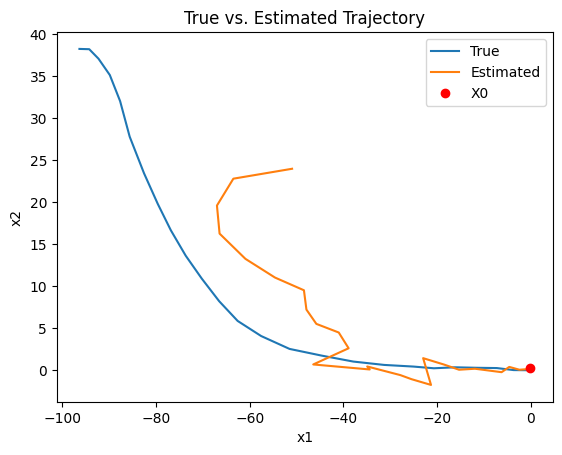

In [145]:
# Particle filter without resampling
N = 10000
resampling_cov = np.array([[0.5**2, 0, 0, 0], [0, 0.005**2, 0, 0], [0, 0, 0.3**2, 0], [0, 0, 0, 0.01**2]])
particles = np.random.multivariate_normal(X0, resampling_cov, size=N)
weights = np.ones(N) / N

estimated_states = []
errors = []
measurement_var = 0.005

for t in range(1, len(Y_vec)):
    # 1) Predict step
    noise = np.random.multivariate_normal(np.zeros(4), eps1t_cov, size=N)
    particles = (A @ particles.T).T + noise

    # 2) Compute importance weights
    y_pred = np.arctan2(particles[:,0], particles[:,2])
    # Gaussian likelihood (up to constant)
    w = np.exp(-0.5 * (Y_vec[t] - y_pred)**2 / measurement_var)
    weights *= w
    weights /= np.sum(weights)

    # 3) State estimate
    x_hat = weights @ particles    # shape (4,)
    estimated_states.append(x_hat)

    # 4) Mean absolute error
    err = np.mean(np.abs(particles - x_hat))
    errors.append(err)

final_weights = weights

# --- Plots ---
true_arr = np.array(X_vec)                    # shape (26,4)
est_arr = np.vstack((X0, estimated_states))   # shape (26,4)
t = np.arange(est_arr.shape[0])

# True vs. estimated trajectory in (x1,x2)
plt.figure()
plt.plot(true_arr[:,0], true_arr[:,2], label='True')
plt.plot(est_arr[:,0],  est_arr[:,2],  label='Estimated')
plt.plot(X0[0], X0[2], 'ro', label='X0')
plt.xlabel('x1'); plt.ylabel('x2')
plt.title('True vs. Estimated Trajectory')
plt.legend()
plt.show()

## 3. Particle Filter Algorithm with Bootstrap Resampling

Use particle filtering to estimate the state of the object at time $t = 1, \ldots, 25$. This time perform bootstrap resampling whenever the effective sample size is less than $N_{eff} = 0.5 N$.
Provide the following:

1. Generate $N= 10,000$ particles distributed according to $N(X_0, \Sigma_0)$, where
$$
\Sigma_0 = \begin{pmatrix}
0.5^2 & 0 & 0 & 0 \\
0 & 0.005^2 & 0 & 0 \\
0 & 0 & 0.3^2 & 0 \\
0 & 0 & 0 & 0.01^2
\end{pmatrix}.
$$
2. Plot the true trajectory and the estimated trajectory at each time step. Mark the starting point of the trajectory with a red dot.

Store the following for each time step for comparison:

1. Weights of the particles at the final time step.
2. Estimation errors = $\frac{1}{N} \sum_{i=1}^N |X_t^{(i)} - \hat{X}_t|$ at each time step, where $\hat{X}_t$ is the estimated state at time $t$.

/var/folders/gj/76ncjg5s4hz3x1h644w2l4rm0000gn/T/ipykernel_72702/531568484.py:13: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  noise = np.random.multivariate_normal(np.zeros(4), eps1t_cov, size=N)


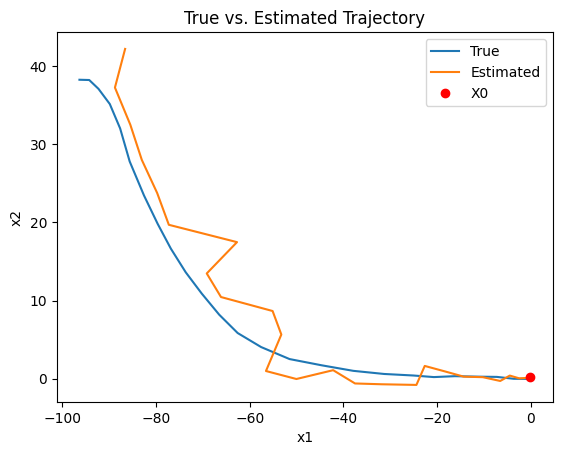

In [146]:
# Particle filter with resampling
N = 10000
resampling_cov = np.array([[0.5**2, 0, 0, 0], [0, 0.005**2, 0, 0], [0, 0, 0.3**2, 0], [0, 0, 0, 0.01**2]])
particles = np.random.multivariate_normal(X0, resampling_cov, size=N)
weights = np.ones(N) / N

estimated_states_res = []
errors_res = []
measurement_var = 0.005

for t in range(1, len(Y_vec)):
    # 1) Predict
    noise = np.random.multivariate_normal(np.zeros(4), eps1t_cov, size=N)
    particles = (A @ particles.T).T + noise

    # 2) Weigh
    y_pred = np.arctan2(particles[:,0], particles[:,2])
    w = np.exp(-0.5 * (Y_vec[t] - y_pred)**2 / measurement_var)
    weights *= w
    weights /= weights.sum()

    # 2.5) Resample if Neff too low
    Neff = 1.0 / np.sum(weights**2)
    if Neff < 0.5 * N:
        indices = np.random.choice(N, size=N, p=weights)
        particles = particles[indices]
        weights.fill(1.0 / N)

    # 3) Estimate and error
    x_hat = weights @ particles
    estimated_states_res.append(x_hat)
    err = np.mean(np.abs(particles - x_hat))
    errors_res.append(err)

final_weights_res = weights

# --- Plots ---
true_arr = np.array(X_vec)                    # shape (26,4)
est_arr = np.vstack((X0, estimated_states_res))   # shape (26,4)
t = np.arange(est_arr.shape[0])

# True vs. estimated trajectory in (x1,x2)
plt.figure()
plt.plot(true_arr[:,0], true_arr[:,2], label='True')
plt.plot(est_arr[:,0],  est_arr[:,2],  label='Estimated')
plt.plot(X0[0], X0[2], 'ro', label='X0')
plt.xlabel('x1'); plt.ylabel('x2')
plt.title('True vs. Estimated Trajectory')
plt.legend()
plt.show()

## 4. Compare the two particle filter algorithms
1. In the same plot, plot the errors of the two algorithms at each time step.
2. In a side by side plot, plot the sorted weights of the particles at the final time step for both algorithms.


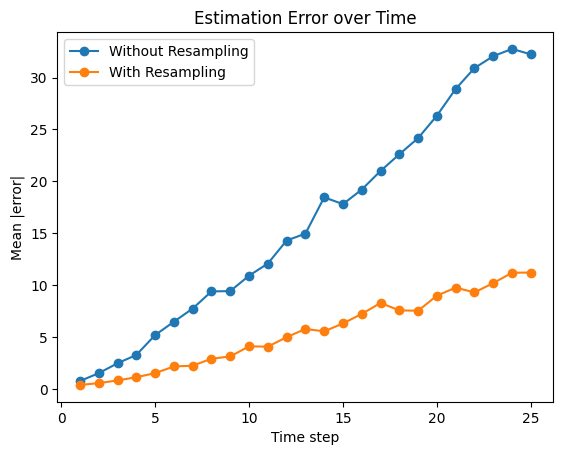

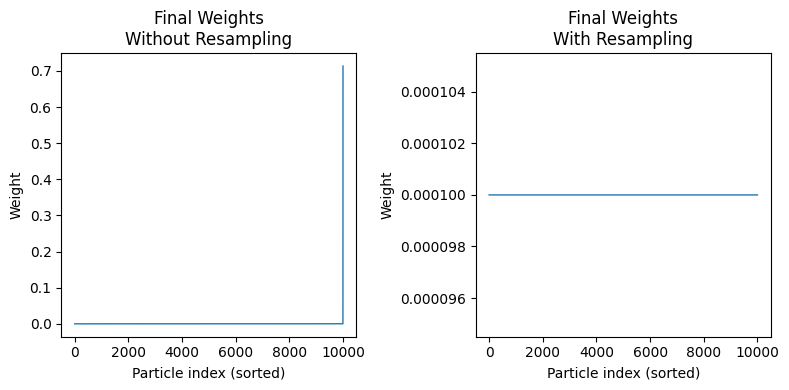

In [147]:
# Comparison
plt.figure()
plt.plot(t[1:], errors, marker='o', label='Without Resampling')
plt.plot(t[1:], errors_res, marker='o', label='With Resampling')
plt.xlabel('Time step'); plt.ylabel('Mean |error|')
plt.title('Estimation Error over Time')
plt.legend()
plt.show()

final_weights.sort()
final_weights_res.sort()

plt.figure(figsize=(8,4))
# left: without resampling
plt.subplot(1, 2, 1)
plt.plot(final_weights, linewidth=1)
plt.title('Final Weights\nWithout Resampling')
plt.xlabel('Particle index (sorted)')
plt.ylabel('Weight')

# right: with resampling
plt.subplot(1, 2, 2)
plt.plot(final_weights_res, linewidth=1)
plt.title('Final Weights\nWith Resampling')
plt.xlabel('Particle index (sorted)')
plt.ylabel('Weight')

plt.tight_layout()
plt.show()